In [1]:
# Setup

import pickle
import sklearn
from sklearn import cluster
import cv2
import numpy as np
import math
import time


# array processing functions

def getInterpolationDistribution(lenData, lenArray):
    interpCount = max(0, lenArray - lenData)
    # start with all the interpolations
    distribution = np.ones(lenData)
    i = 0
    currentSum = lenData
    while currentSum < lenArray:
        i=0
        while i < lenData and currentSum < lenArray:
            distribution[i] += 1
            currentSum += 1
            interpCount -=1
            i+=1            
    theSum = 0
    for v in distribution:
        theSum += v
    return distribution


def lerp(a, b, t):
    af = (float(a[0]), float(a[1]))
    bf = (float(b[0]), float(b[1]))
    x =  af[0] + t * (bf[0] - af[0]);
    y =  af[1] + t * (bf[1] - af[1]);
    return np.array([x,y])


def addInterpolations(inputData):
    processedArray = np.zeros([512, 2])

    interpDistribution = getInterpolationDistribution(len(inputData), 512)    
    iProcessed = 0
    iInput = 0
    div = 0
    
    for interp in interpDistribution:
        while interp > 0:
            if interp > 1:
                if interp > div:
                    div = float(interp)
                # interpolate
                a=0
                b=0
                if iInput==0:
                    a=inputData[0]
                    b=inputData[0]
                elif iInput >= len(inputData)-1:
                    a=inputData[len(inputData)-2]
                    b=inputData[len(inputData)-1]    
                else :
                    a = inputData[iInput - 1]
                    b = inputData[iInput]
                processedArray[iProcessed] = lerp(a,b, (div-interp)/div)
            else:
                # take next value from input
                processedArray[iProcessed] = inputData[iInput]
                iInput += 1
            interp -= 1
            iProcessed += 1

    return processedArray



def vectorise(src):
    # normalise the input image
    maxVal = 0.0
    for element in src:
        if abs(element[0]) > maxVal:
            maxVal = math.fabs(element[0])
        if abs(element[1]) > maxVal:
            maxVal = math.fabs(element[1])

    normalised = np.zeros([len(src),2])       
    for i, element in enumerate(src):
        normalised[i] = np.array([element[0] / maxVal,element[1] / maxVal])

    # calculate the vectors
    vectorised = np.zeros(len(src)*2)   

    for i, element in enumerate(normalised):
        if i < len(src)-1:
            vectorised[i*2] = normalised[i][0] - normalised[i+1][0]
            vectorised[(i*2) + 1] = normalised[i][1] - normalised[i+1][1]  
    return vectorised


# read the data
with open ('processedTrackPadDataFile', 'rb') as fp:
    itemlist = pickle.load(fp)

# cluster
kmeans = sklearn.cluster.KMeans(n_clusters=6)
kmeans_target = kmeans.fit_predict(itemlist)
          
print kmeans_target
print kmeans.cluster_centers_ 




[3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 2 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 4 4 0 0 0 0 0 4 0 0 0
 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 4 5 4 4 4 5 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  7.74830965e-04
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.58159618e-04
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.77680777e-

In [3]:
# Set up clusters
clusterMapping = {3: "square", 0:"circle", 5:"heart", 2: "triangle", 1:"Z", 4: "lollypop"  }


    
# gestureEmojiMapping = {"square": "objects", "circle": "natures", "heart" : "peoples", "triangle" : "symbols", "Z" : "activities", "lollypop" : "foods"  }
gestureEmojiMapping = {"square": "Flags", "circle": "Smileys", "heart" : "Hearts", "triangle" : "Symbols", "Z" : "Objects", "lollypop" : "Food"  }



heart: Hearts
3


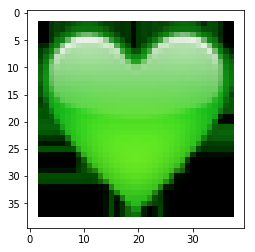

triangle: Symbols
3


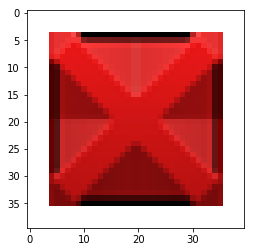

In [4]:
import DrawingWindow
from os import listdir, path
import cv2
import matplotlib.pyplot as plt

def winPath(path):
    p = path.replace('\\','/')
    p = p.replace('//','/')
    return p

def loadEmojis(folder):
    categFolders = [f for f in listdir(folder) if not path.isfile(path.join(folder, f))]
    emojiDict = dict()
    for categ in categFolders:
        catPath = path.join(folder, categ)
        emojis = [f for f in listdir(catPath) if path.isfile(path.join(catPath, f))]
        imgs = []
        for emoji in emojis:
            img = cv2.imread(catPath + '/' + emoji,cv2.IMREAD_UNCHANGED)
            imgs.append(img)
        emojiDict[categ] = imgs
    return emojiDict
            
emojiFolder = winPath(r'D:\edu\phd\Computational Interaction\Group Project\emojiPNG\\')
emojis = loadEmojis(emojiFolder)   


# test an input

w = DrawingWindow.DrawingWindow()
w.setup()

emoji_positions_x = []
emoji_positions_y = []
emoji_index = 0
emojiImagesForCategory = []

while(1):
    event = w.draw()
    if event == -1:
        break
    if w.draw() == 1:
        gestureIn = w.getLatestData()
        # w.close()
        yPos = 10
        xPos = 400
        w.clear()
        categoryMatch = kmeans.predict(vectorise(addInterpolations(gestureIn)).reshape(1, -1))[0]
        emojiImagesForCategory = emojis[gestureEmojiMapping[clusterMapping[categoryMatch]]]
        for e in emojiImagesForCategory:
            w.displayImg(e, xPos, yPos)
            emoji_positions_x.append([yPos, yPos+40])
            emoji_positions_y.append([xPos, xPos+40])
            if (yPos + 40) < 460:
                yPos = yPos + 40
            else:
                yPos = 10
                xPos = xPos + 40
        print clusterMapping[categoryMatch] + ": " + gestureEmojiMapping[clusterMapping[categoryMatch]] 
    else: 
        click, isNew = w.getClick()
        if isNew == True:
            for y_position in emoji_positions_y:
                if click[1] >= 400 and click[1] < 440:
                    try:
                        for x_position in emoji_positions_x[:12]:
                            if click[0] >= x_position[0] and click[0] < x_position[1]:
                                emoji_index = emoji_positions_x.index(x_position)
                    except:
                        for x_position in emoji_positions_x:
                            if click[0] >= x_position[0] and click[0] < x_position[1]:
                                emoji_index = emoji_positions_x.index(x_position)
            
                else:
                    for x_position in emoji_positions_x[12:]:
                            if click[0] >= x_position[0] and click[0] < x_position[1]:
                                emoji_index = emoji_positions_x.index(x_position)+12

            print emoji_index
            
            plt.imshow( cv2.cvtColor(emojiImagesForCategory[emoji_index],cv2.COLOR_BGR2RGB))
            plt.show()
        
        
# todo 


# future:
# find distances
# rotate and mirror vectors for robustness to phase shift
# Supervised learning for cleanup 


In [ ]:
#test draw

import DrawingWindow
import matplotlib.pyplot as plt
from os import listdir, path
import cv2

def winPath(path):
    p = path.replace('\\','/')
    p = p.replace('//','/')
    return p

def loadEmojis(folder):
    categFolders = [f for f in listdir(folder) if not path.isfile(path.join(folder, f))]
    emojiDict = dict()
    for categ in categFolders:
        catPath = path.join(folder, categ)
        emojis = [f for f in listdir(catPath) if path.isfile(path.join(catPath, f))]
        imgs = []
        for emoji in emojis:
            imgs.append(cv2.imread(catPath + '/' + emoji,cv2.IMREAD_UNCHANGED))
        emojiDict[categ] = imgs
    return emojiDict
            
emojiFolder = winPath(r'D:\edu\phd\Computational Interaction\Group Project\emojiPNG\\')
emojis = loadEmojis(emojiFolder)   



w = DrawingWindow.DrawingWindow()
w.setup()

yPos = 10
xPos = 350
for e in emojis["Hearts"]:
            w.displayImg(e, xPos, yPos)
            if (yPos + 40) < 460:
                yPos = yPos + 40
            else:
                yPos = 10
                xPos = xPos + 40


while(1):
    event = w.draw()
    if event == -1:
        break